In [31]:
# !pip3 install librosa
# !pip3 install praat-parselmouth
# !pip3 install pydub
# !pip3 install mutagen
# !pip3 install noisereduce

### Necessary Imports

In [118]:
import numpy as np
import pandas as pd
import librosa
# from model import manual_linear_regression  # Importing the custom developed linear regression model based on the matrix approach to utilize for model training process
# # Currently, the implementation of the respective model has been integrating into this notebook for avoid any module based anamolies; whereas in order to better code based modularity this approach is more preferred

# Utility imports
import parselmouth
import io
import os
import tempfile
import pydub
from mutagen.mp3 import MP3
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
import noisereduce as nr

### Loading the Training Data

In [33]:
train_metadata = pd.read_csv("C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\truncated_train.csv")

### **EDA:** For, initial state of the training dataset

In [35]:
train_metadata.head()

filename  \
0  cv-valid-train/sample-000000.mp3   
1  cv-valid-train/sample-000001.mp3   
2  cv-valid-train/sample-000002.mp3   
3  cv-valid-train/sample-000003.mp3   
4  cv-valid-train/sample-000004.mp3   

                                                text  up_votes  down_votes  \
0  learn to recognize omens and follow them the o...         1           0   
1         everything in the universe evolved he said         1           0   
2  you came so that you could learn about your dr...         1           0   
3  so now i fear nothing because it was those ome...         1           0   
4  if you start your emails with greetings let me...         3           2   

   age gender accent  duration  
0  NaN    NaN    NaN       NaN  
1  NaN    NaN    NaN       NaN  
2  NaN    NaN    NaN       NaN  
3  NaN    NaN    NaN       NaN  
4  NaN    NaN    NaN       NaN

In [ ]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15001 entries, 0 to 15000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    15001 non-null  object 
 1   text        15001 non-null  object 
 2   up_votes    15001 non-null  int64  
 3   down_votes  15001 non-null  int64  
 4   age         5615 non-null   object 
 5   gender      5626 non-null   object 
 6   accent      4933 non-null   object 
 7   duration    0 non-null      float64
dtypes: float64(1), int64(2), object(5)
memory usage: 937.7+ KB


In [ ]:
train_metadata.describe()

up_votes    down_votes  duration
count  15001.000000  15001.000000       0.0
mean       2.545964      0.179788       NaN
std        7.579492      4.377489       NaN
min        1.000000      0.000000       NaN
25%        1.000000      0.000000       NaN
50%        2.000000      0.000000       NaN
75%        3.000000      0.000000       NaN
max      745.000000    528.000000       NaN

In [ ]:
train_metadata.isnull().sum()

filename          0
text              0
up_votes          0
down_votes        0
age            9386
gender         9375
accent        10068
duration      15001
dtype: int64

### Feature Extraction

***Note:** Through the EDA of initial (original) state of the dataset; there happened to be no missing values within the column that contained the paths to the audio files. Therefore, it is safe to proceed towards feature extraction for the audio files and maintaining a training dataset for training the respective regression model.

##### Utility functions for feature extraction process

In [ ]:
def path_format_correction(audio_path):
    base_directory = r"C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset"

    escaped_path = audio_path.replace('/', '\\\\')

    return "\\\\".join([base_directory, escaped_path])

def get_mp3_codec(mp3_file):
    
    try:
        audio = MP3(mp3_file)
        codec = audio.info.codec
    
        return codec
    
    except Exception as e:
        print(f"Error getting MP3 codec: {e}")
    
        return None

def load_audio_from_mp3(mp3_file):
    
    try:
        # Loading the MP3 file using pydub
        audio = pydub.AudioSegment.from_mp3(mp3_file)

        # # Exporting the audio to WAV format in memory (as bytes)
        # wav_bytes = io.BytesIO()
        # audio.export(wav_bytes, format="wav")

        # # Resetting the byte stream position to the beginning
        # wav_bytes.seek(0)

        # Creating a temporary WAV file
        temp_wav_file = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        # temp_wav_file.close()  # Closing the file to allow opening in write mode

        # Exporting the audio to the temporary WAV file
        audio.export(temp_wav_file.name, format="wav")

        # Loading the audio data from the temporary WAV file using librosa
        y, sr = librosa.load(temp_wav_file.name)

        # Cleaning up the temporary WAV file
        os.unlink(temp_wav_file.name)

        return y, sr

    except Exception as e:
        print(f"Error loading audio from MP3 file: {e}")
        
        return None, None
    
# def calculate_formants(audio_path, num_formants=5):
    
#     try:
#         # Loading audio using pydub (convert to WAV format)
#         audio = pydub.AudioSegment.from_file(audio_path)
#         audio.export("temp.wav", format="wav")

#         # Opening WAV file with parselmouth
#         sound = parselmouth.Sound("temp.wav")

#         # Extracting formant measurements using Praat's To Formant (burg) function
#         formant = sound.to_formant_burg(num_formants=num_formants)

#         # Getting formant frequencies
#         formant_freqs = [formant.get_value_at_time(i, 0) for i in range(1, num_formants + 1)]

#         return formant_freqs

#     except Exception as e:
#         print(f"Error calculating formants for audio {audio_path}: {e}")
        
#         return None

def estimate_formants(audio_path, audio, sr):
    
    try:
        # Performing LPC analysis to estimate filter coefficients
        order = 8  # LPC order (number of coefficients)
        lpc_coeffs = librosa.lpc(audio, order=order)

        # Computing the frequency response of the LPC filter
        freq_response = np.fft.fft(lpc_coeffs, n=1024)
        freq_response = freq_response[:len(freq_response) // 2]  # Keeping only positive frequencies

        # Finding peaks in the frequency response (formant frequencies)
        peaks, _ = find_peaks(np.abs(freq_response))

        # Converting peak indices to frequencies (Hz)
        formants = peaks * (sr / 2) / len(freq_response)

        return formants.tolist()
    
    except Exception as e:
        print(f"Error calculating formants for audio {audio_path}: {e}")

        return None

def calculate_intensity(audio_path, y, frame_length=2048, hop_length=512):
    
    try:
        # Computing Short-Time Fourier Transform (STFT)
        D = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)

        # Calculating magnitude spectrogram
        magnitude_spectrogram = np.abs(D)

        # Computing energy (sum of squared magnitude spectrogram)
        energy = np.sum(magnitude_spectrogram**2)

        return energy

    except Exception as e:
        print(f"Error calculating intensity for audio {audio_path}: {e}")

        return None
    
def extract_audio_features(audio_path, y, sr):

    try:

        # Calculating pitch (fundamental frequency - F0)
        pitches, magnitudes=librosa.core.piptrack(y=y, sr=sr, fmin=99, fmax=351)

        formants = estimate_formants(audio_path, y, sr)

        # Calculating intensity (energy of the audio signal; using STFT)
        energy = calculate_intensity(audio_path, y)

        # Calculating duration (length of audio in seconds)
        duration = librosa.get_duration(y=y, sr=sr)

        # Extracting spectral features (example using MFCC)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        return (pitches.mean(), formants, energy, duration, mfccs)

    except Exception as e:
        print(f"Error extracting features from audio {audio_path}: {e}")
        
        return None

##### Driver function for audio feature extraction

In [ ]:
audio_data_list = []

for index, row in train_metadata.iterrows():
    audio_path = path_format_correction(row['filename'])

    # # For, testing
    # print(audio_path)
    # print(type(audio_path))
    # print(get_mp3_codec(audio_path))
    
    try:
        # Loading audio file using librosa
        audio, sr = librosa.load(audio_path)
        # audio, sr = load_audio_from_mp3(audio_path)

        # Extracting the relevant audio features
        f0, formants, energy, duration, mfccs=extract_audio_features(audio_path, audio, sr)
        
        # Appending loaded audio data to the list
        audio_data_list.append({
            'filename': audio_path,
            "transcription": row["text"],
            "up_votes": row["up_votes"],
            "down_votes": row["down_votes"],
            "age": row["age"],
            "gender": row["gender"],
            "accent": row["accent"],
            'audio_data': audio,
            'sample_rate': sr,
            "duration": duration,
            'pitch_f0': f0,
            'formants': formants,
            'intensity_rms': energy,
            'mfccs': mfccs
        })
        
        print(f"Loaded audio: {audio_path}")
        
    except Exception as e:
        print(f"Error loading audio {audio_path}: {e}")

audio_data_df = pd.DataFrame(audio_data_list)

Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000000.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000001.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000002.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000003.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000004.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000005.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000006.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000007.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485

In [ ]:
# audio_data_df.to_csv("audio_features.csv", index=False) 

### Data Preprocessing

##### _Loading the extracted audio feature data file_

In [ ]:
# audio_data_df=pd.read_csv("audio_features.csv")

##### _**EDA:** For, preprocessed data_

In [ ]:
audio_data_df.head()

filename  \
0  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
1  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
2  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
3  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
4  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   

                                       transcription  up_votes  down_votes  \
0  learn to recognize omens and follow them the o...         1           0   
1         everything in the universe evolved he said         1           0   
2  you came so that you could learn about your dr...         1           0   
3  so now i fear nothing because it was those ome...         1           0   
4  if you start your emails with greetings let me...         3           2   

   age gender accent                                         audio_data  \
0  NaN    NaN    NaN  [-5.9227658e-11  1.6258904e-11  3.5964388e-11 ...   
1  NaN    NaN    NaN  [ 1.5570863e-12  1.9885526e-12  5.0891769e-12 ...   
2  NaN    NaN    NaN  [-1.5786802e-11 -4.9093251e-12 -7.5024278e-11 ...   
3  NaN    NaN    NaN  [-1.5923391e-11  2.6508585e-11 -9.1306103e-12 ...   
4  NaN    NaN    NaN  [1.0412913e-08 9.2886254e-12 2.6633327e-09 ......   

   sample_rate  duration  pitch_f0                          formants  \
0        22050  4.104036  0.786654                  [4414.306640625]   
1        22050  7.560000  1.179417                   [7019.82421875]   
2        22050  5.064036  0.702323                   [2540.91796875]   
3        22050  6.648027  0.796759  [4242.041015625, 7773.486328125]   
4        22050  4.896009  0.691152  [4586.572265625, 7472.021484375]   

   intensity_rms                                              mfccs  
0   9.351184e+05  [[-6.2080945e+02 -5.7794458e+02 -5.4704071e+02...  
1   1.528066e+03  [[-9.0220477e+02 -8.0572845e+02 -7.5700232e+02...  
2   5.292675e+05  [[-6.2587244e+02 -4.2121130e+02 -2.8344016e+02...  
3   2.952364e+04  [[-7.2959540e+02 -6.6083923e+02 -6.2344287e+02...  
4   3.355327e+07  [[-310.23752   -147.01956   -123.98564   ... -...

In [ ]:
audio_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15001 entries, 0 to 15000
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       15001 non-null  object 
 1   transcription  15001 non-null  object 
 2   up_votes       15001 non-null  int64  
 3   down_votes     15001 non-null  int64  
 4   age            5615 non-null   object 
 5   gender         5626 non-null   object 
 6   accent         4933 non-null   object 
 7   audio_data     15001 non-null  object 
 8   sample_rate    15001 non-null  int64  
 9   duration       15001 non-null  float64
 10  pitch_f0       15001 non-null  float64
 11  formants       15001 non-null  object 
 12  intensity_rms  15001 non-null  float64
 13  mfccs          15001 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 1.6+ MB


In [ ]:
audio_data_df.describe()

up_votes    down_votes  sample_rate      duration      pitch_f0  \
count  15001.000000  15001.000000      15001.0  15001.000000  15001.000000   
mean       2.545964      0.179788      22050.0      4.421937      0.800489   
std        7.579492      4.377489          0.0      1.985715      0.174962   
min        1.000000      0.000000      22050.0      1.056009      0.042256   
25%        1.000000      0.000000      22050.0      3.096009      0.692745   
50%        2.000000      0.000000      22050.0      4.080000      0.815561   
75%        3.000000      0.000000      22050.0      5.376009      0.922846   
max      745.000000    528.000000      22050.0     56.184036      1.388861   

       intensity_rms  
count   1.500100e+04  
mean    9.974380e+05  
std     2.011128e+06  
min     6.190663e-01  
25%     9.543173e+04  
50%     3.745406e+05  
75%     1.162244e+06  
max     7.288005e+07

In [ ]:
audio_data_df.isnull().sum()

filename             0
transcription        0
up_votes             0
down_votes           0
age               9386
gender            9375
accent           10068
audio_data           0
sample_rate          0
duration             0
pitch_f0             0
formants             0
intensity_rms        0
mfccs                0
dtype: int64

##### _Data Visualization of the extracted audio features_

In [ ]:
numerical_features = ['sample_rate', 'up_votes', 'down_votes', 'duration', 'pitch_f0', 'intensity_rms']

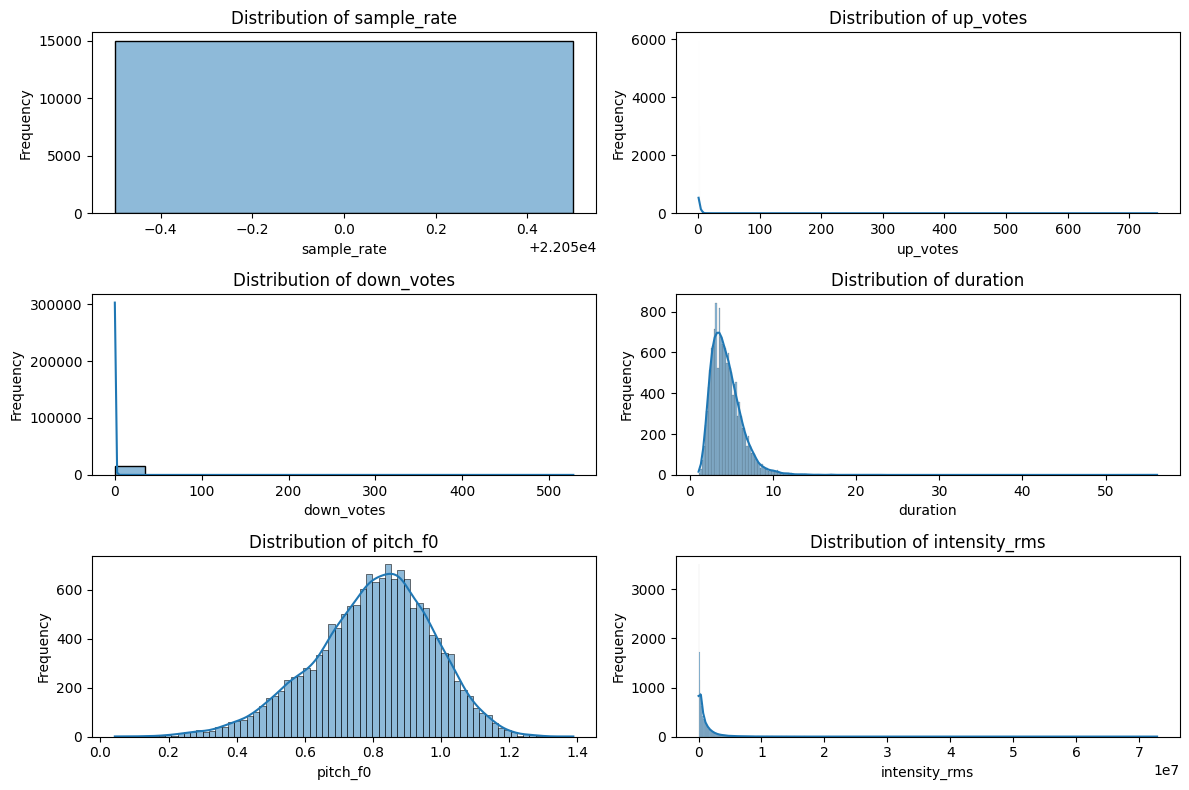

In [ ]:
# Plotting histograms to visualize distribution of numerical features
plt.figure(figsize=(12, 8))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(audio_data_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

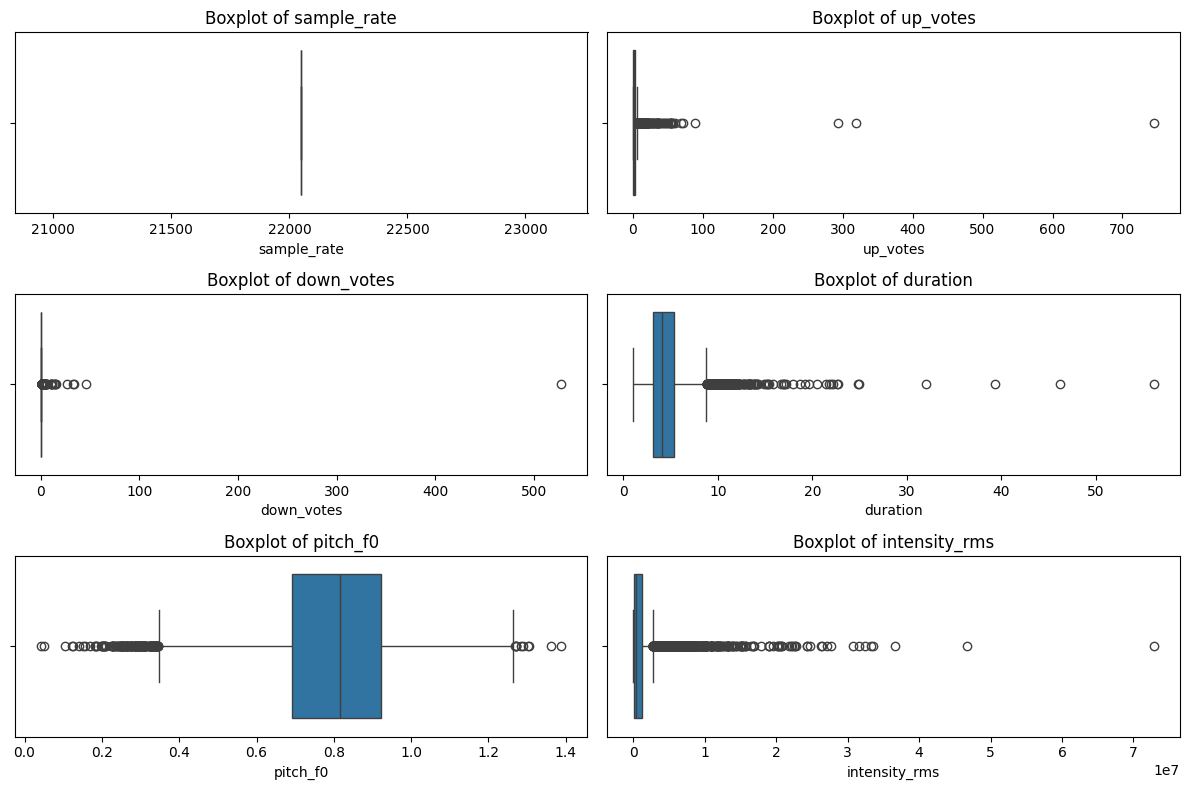

In [ ]:
# Detecting outliers using boxplots
plt.figure(figsize=(12, 8))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=audio_data_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluating the presence of outliers using statistical methods (e.g., IQR)
Q1 = audio_data_df[numerical_features].quantile(0.25)
Q3 = audio_data_df[numerical_features].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df[numerical_features] < (Q1 - 1.5 * IQR)) | (audio_data_df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)
num_outliers = outliers.sum()

print(f"Total number of outliers; across the numerical features: {num_outliers}")

Total number of outliers; across the numerical features: 3360


In [ ]:
Q1 = audio_data_df["sample_rate"].quantile(0.25)
Q2 = audio_data_df["sample_rate"].median()
Q3 = audio_data_df["sample_rate"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df["sample_rate"] < (Q1 - 1.5 * IQR)) | (audio_data_df["sample_rate"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the sample_rate feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the sample_rate feature: 
> Q1; 22050.0
> Q2; 22050.0
> Q3; 22050.0
> Number of outliers; 0


In [ ]:
Q1 = audio_data_df["duration"].quantile(0.25)
Q2 = audio_data_df["duration"].median()
Q3 = audio_data_df["duration"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df["duration"] < (Q1 - 1.5 * IQR)) | (audio_data_df["duration"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the duration feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the duration feature: 
> Q1; 3.0960090702947847
> Q2; 4.08
> Q3; 5.376009070294785
> Number of outliers; 373


In [ ]:
Q1 = audio_data_df["pitch_f0"].quantile(0.25)
Q2 = audio_data_df["pitch_f0"].median()
Q3 = audio_data_df["pitch_f0"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df["pitch_f0"] < (Q1 - 1.5 * IQR)) | (audio_data_df["pitch_f0"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the pitch_f0 feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the pitch_f0 feature: 
> Q1; 0.6927446
> Q2; 0.81556064
> Q3; 0.9228462
> Number of outliers; 167


In [ ]:
Q1 = audio_data_df["intensity_rms"].quantile(0.25)
Q2 = audio_data_df["intensity_rms"].median()
Q3 = audio_data_df["intensity_rms"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df["intensity_rms"] < (Q1 - 1.5 * IQR)) | (audio_data_df["intensity_rms"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the intensity_rms feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the intensity_rms feature: 
> Q1; 95431.73
> Q2; 374540.6
> Q3; 1162243.8
> Number of outliers; 1250


##### Data Cleaning

- **For handling missing values:** Performing mean value imputation on the columns that have missing values

***Note:** Handling the corner case of mapping out integer based values from the categorical nature of the age column of our respective data

In [47]:
age_mapping = {
    'teens': 15,
    'twenties': 25,
    'thirties': 35,
    'fourties': 45,
    'fifties': 55,
    'sixties': 65,
    'seventies': 75,
    'eighties': 85
}

gender_mapping = {
    'male': 0,
    'female': 1
}

# Mapping the categorical gender labels to numerical values
audio_data_df['gender_mapped'] = audio_data_df['gender'].map(gender_mapping)

# Mapping the categorical age labels to numerical values
audio_data_df['age'] =audio_data_df['age'].map(age_mapping)

# Replacing NaN values in 'age' column with 0.00
audio_data_df['age'].fillna(0.00, inplace=True)

# Converting the 'age' column to integer type
audio_data_df['age'] = audio_data_df['age'].astype(int)

# Calculating mean values for columns with missing values
mean_age =audio_data_df[audio_data_df['age'] != 0]['age'].mean()
mean_gender = audio_data_df['gender'].mode()[0]  # Mode for categorical variables like gender and accent
mean_accent = audio_data_df['accent'].mode()[0]  

# Imputing missing values with mean values
audio_data_df.loc[audio_data_df['age'] == 0, 'age'] = mean_age
audio_data_df['age'] =audio_data_df['age'].astype(int)

audio_data_df['gender'].fillna(mean_gender, inplace=True)
audio_data_df['accent'].fillna(mean_accent, inplace=True)

In [ ]:
# Verifying that missing values have been filled
print(audio_data_df.isnull().sum())

filename         0
transcription    0
up_votes         0
down_votes       0
age              0
gender           0
accent           0
audio_data       0
sample_rate      0
duration         0
pitch_f0         0
formants         0
intensity_rms    0
mfccs            0
dtype: int64


##### Data Cleaning: (Feature based)

- Performing feature based data cleaning on the by performing the following operations:
    - Noise reduction; through noise gating
    - Audio trimming; to ensure filtering out tailing signals

***Note:** In order to ensure more accurate data modelling; maintaining a seperate dataset which additional extracted features

In [ ]:
def resize_spectrogram(spec, length, fact=-80):

    # Creating an empty canvas to put spectrogram into
    canvas = np.ones((len(spec), length)) * fact

    if spec.shape[1] <= length:
        canvas[:, : spec.shape[1]] = spec
    else:
        canvas[:, :length] = spec[:, :length]
    return canvas

def compute_mel_spec(y, sr, hop_length=512, duration=3.0):
    # Computing the mel spectrogram
    x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Applying logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref=np.max)

    # Computing mean strength per frequency for mel spectrogram
    mel_strength = np.mean(x_mel, axis=1)

    # Estimating the desired length of the spectrogram
    length = int(duration * sr / hop_length)

    # Putting mel spectrogram into the right shape
    x_mel = resize_spectrogram(x_mel, length, fact=-80)

    return x_mel, mel_strength

In [39]:
# # For, testing
# audio_path="C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000000.MP3"

# audio, sr = librosa.load(audio_path)

# reduced_noise=nr.reduce_noise(y=audio, sr=sr)

# y_trim=librosa.effects.trim(audio, top_db=21)

# onsets=librosa.onset.onset_detect(y=audio, sr=sr, units='time', hop_length=129, backtrack=False)

# number_of_words=len(onsets)

# tempo=librosa.beat.tempo(y=audio, sr=sr)[0]

# mel_spec=compute_mel_spec(y=audio, sr=sr)
# mels=mel_spec[0]
# mel_strength=mel_spec[1]

In [40]:
noise_reduced_audio_list = []

for index, row in audio_data_df.iterrows():
    audio_path = row['filename']

    try:
        audio, sr = librosa.load(audio_path)
    
        # # y = row['audio_data']
        # y = np.array(row['audio_data'])
        # sr = row['sample_rate']
    
        # # For, testing
        # print(type(y))
        # print(type(sr))
        # print(y)
        # print(y.shape)

        reduced_noise=nr.reduce_noise(y=audio, sr=sr)

        y_trim=librosa.effects.trim(audio, top_db=21)

        onsets=librosa.onset.onset_detect(y=audio, sr=sr, units='time', hop_length=129, backtrack=False)

        number_of_words=len(onsets)

        tempo=librosa.beat.tempo(y=audio, sr=sr)[0]

        mel_spec=compute_mel_spec(y=audio, sr=sr)
        mels=mel_spec[0]
        mel_strength=mel_spec[1]

        # Appending loaded audio data to the list
        noise_reduced_audio_list.append({
            'noise_reduced': reduced_noise,
            'trimmed_audio': y_trim,
            'onsets': onsets,
            'number_of_words': number_of_words,
            'tempo': tempo,
            'mels': mels,
            'mel_strength':mel_strength
        })

        print(f"Loaded audio: {audio_path}")
        
    except Exception as e:
        print(f"Error loading audio {audio_path}: {e}")


secondary_audio_data_df = pd.DataFrame(noise_reduced_audio_list)

Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000000.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000001.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000002.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000003.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000004.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000005.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000006.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Dataset\\cv-valid-train\\sample-000007.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485

In [27]:
additional_audio_list = []

for index, row in audio_data_df.iterrows():
    audio_path = row['filename']
    audio_path=audio_path.replace('Dataset', 'Datasets')

    try:
        audio, sr = librosa.load(audio_path)

        # Computing the Short-Time Fourier Transform (STFT)
        D = librosa.stft(audio, n_fft=2048, hop_length=512)

        # Converting amplitude spectrogram to dB-scaled spectrogram (power to dB)
        spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
        contrast = np.mean(librosa.feature.spectral_contrast(S=spectrogram, sr=sr))

        # Appending loaded audio data to the list
        additional_audio_list.append({
            'centroid_mean': centroid,
            'bandwidth_mean': bandwidth,
            'contrast_mean': contrast
        })

        print(f"Loaded audio: {audio_path}")
        
    except Exception as e:
        print(f"Error loading audio {audio_path}: {e}")


additional_audio_data_df = pd.DataFrame(additional_audio_list)

Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000000.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000001.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000002.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000003.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000004.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000005.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000006.mp3
Loaded audio: C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-Project-Phase2\\Datasets\\cv-valid-train\\sample-000007.mp3
Loaded audio: C:\\Users\\user\\Desktop\\

In [29]:
# secondary_audio_data_df.to_csv("secondary_audio_features.csv", index=False) 
# additional_audio_data_df.to_csv("additional_audio_data_df.csv", index=False) 

In [30]:
# audio_data_df=pd.read_csv("audio_features_processed.csv")
# audio_data_df=pd.read_csv("audio_features_processed_updated.csv")

In [31]:
# audio_data_df = pd.concat([audio_data_df, secondary_audio_data_df], axis=1)
# audio_data_df = pd.concat([audio_data_df, additional_audio_data_df], axis=1)

In [46]:
f0_mean = audio_data_df['pitch_f0'].mean()
f0_median = audio_data_df['pitch_f0'].median()
f0_std = audio_data_df['pitch_f0'].std()
f0_5perc = np.percentile(audio_data_df['pitch_f0'], 5)
f0_95perc = np.percentile(audio_data_df['pitch_f0'], 95)

new_columns = {
    'f0_mean': f0_mean,
    'f0_median': f0_median,
    'f0_std': f0_std,
    'f0_5perc': f0_5perc,
    'f0_95perc': f0_95perc
}

audio_data_df = audio_data_df.assign(**new_columns)

##### Data Scaling

In [ ]:
X_duration = audio_data_df['duration'].values
X_pitch = audio_data_df['pitch_f0'].values
X_intensity = audio_data_df['intensity_rms'].values

In [ ]:
X_duration = X_duration.reshape(-1, 1)
X_pitch = X_pitch.reshape(-1, 1)
X_intensity = X_intensity.reshape(-1, 1)

# Performing standardization (Z-score scaling) for pitch feature
scaler_pitch = StandardScaler()
X_pitch_scaled = scaler_pitch.fit_transform(X_pitch)

# Performing robust scaling for duration and intensity features
scaler_duration = RobustScaler()
X_duration_scaled = scaler_duration.fit_transform(X_duration)

scaler_intensity = RobustScaler()
X_intensity_scaled = scaler_intensity.fit_transform(X_intensity)

- **Note:** Making a copy of the dataframe containing the raw extracted features to exibit the scaling process

In [ ]:
audio_data_df_scaled=audio_data_df.copy()

# Updating the scaled features in the copied DataFrame
audio_data_df['pitch_scaled'] = X_pitch_scaled
audio_data_df['duration_scaled'] = X_duration_scaled
audio_data_df['intensity_scaled'] = X_intensity_scaled

audio_data_df_scaled['pitch_scaled'] = X_pitch_scaled
audio_data_df_scaled['duration_scaled'] = X_duration_scaled
audio_data_df_scaled['intensity_scaled'] = X_intensity_scaled

##### _Data Visualization of the scaled audio features_

***Note:** Visualizing the distributive nature of the updated audio features

In [ ]:
scaled_numerical_features = ['pitch_scaled', 'duration_scaled', 'intensity_scaled']

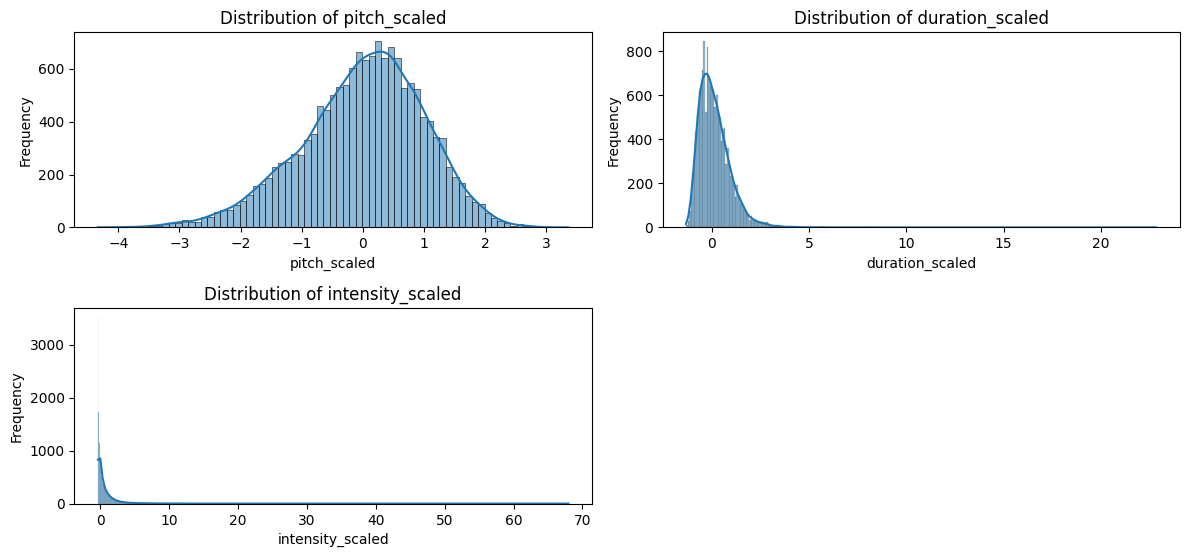

In [ ]:
# Plotting histograms to visualize distribution of numerical features
plt.figure(figsize=(12, 8))

for i, feature in enumerate(scaled_numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(audio_data_df_scaled[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

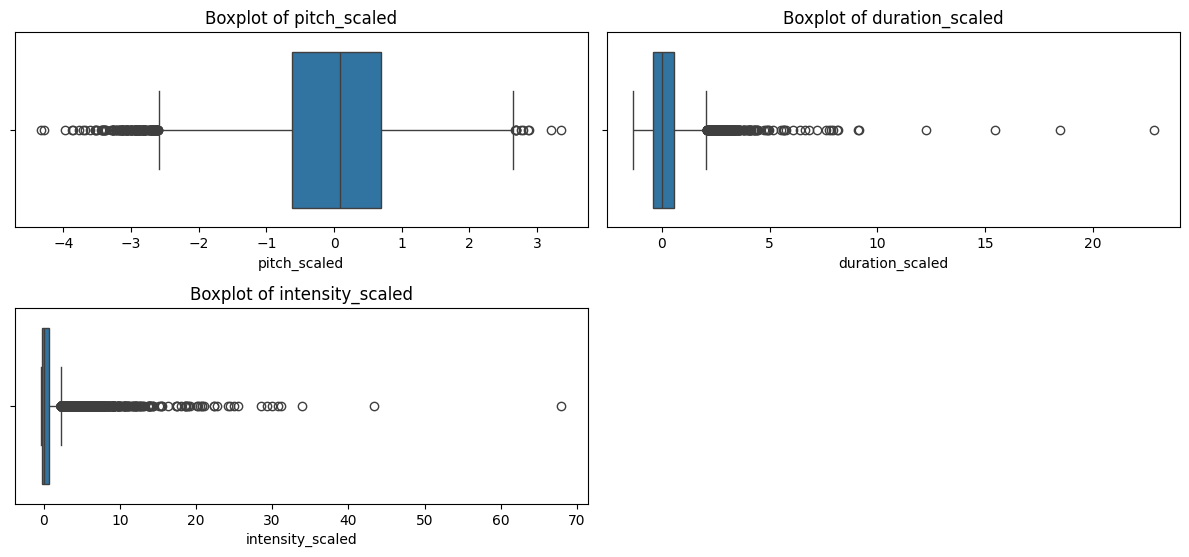

In [ ]:
# Detecting outliers using boxplots
plt.figure(figsize=(12, 8))

for i, feature in enumerate(scaled_numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=audio_data_df_scaled[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
Q1 = audio_data_df_scaled["duration_scaled"].quantile(0.25)
Q2 = audio_data_df_scaled["duration_scaled"].median()
Q3 = audio_data_df_scaled["duration_scaled"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df_scaled["duration_scaled"] < (Q1 - 1.5 * IQR)) | (audio_data_df_scaled["duration_scaled"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the duration_scaled feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the duration_scaled feature: 
> Q1; -0.4315749691689541
> Q2; 0.0
> Q3; 0.5684250308310459
> Number of outliers; 373


In [ ]:
Q1 = audio_data_df_scaled["pitch_scaled"].quantile(0.25)
Q2 = audio_data_df_scaled["pitch_scaled"].median()
Q3 = audio_data_df_scaled["pitch_scaled"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df_scaled["pitch_scaled"] < (Q1 - 1.5 * IQR)) | (audio_data_df_scaled["pitch_scaled"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the pitch_scaled feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the pitch_scaled feature: 
> Q1; -0.6158384724506955
> Q2; 0.08614469007057304
> Q3; 0.699359842600042
> Number of outliers; 167


In [ ]:
Q1 = audio_data_df_scaled["intensity_scaled"].quantile(0.25)
Q2 = audio_data_df_scaled["intensity_scaled"].median()
Q3 = audio_data_df_scaled["intensity_scaled"].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df_scaled["intensity_scaled"] < (Q1 - 1.5 * IQR)) | (audio_data_df_scaled["intensity_scaled"] > (Q3 + 1.5 * IQR)))
num_outliers = outliers.sum()

print("Statistical Analysis for the intensity_scaled feature: ")
print(f"> Q1; {Q1}")
print(f"> Q2; {Q2}")
print(f"> Q3; {Q3}")
print(f"> Number of outliers; {num_outliers}")

Statistical Analysis for the intensity_scaled feature: 
> Q1; -0.2616289015177715
> Q2; 0.0
> Q3; 0.7383710984822285
> Number of outliers; 1250


##### Data Normalization

In [ ]:
# Applying minmax normalization for the respective scaled features
scaler_duration_normalized = MinMaxScaler()
X_duration_normalized = scaler_duration_normalized.fit_transform(X_duration_scaled)

scaler_pitch_normalized = MinMaxScaler()
X_pitch_normalized = scaler_pitch_normalized.fit_transform(X_pitch_scaled)

scaler_intensity_normalized = MinMaxScaler()
X_intensity_normalized = scaler_intensity_normalized.fit_transform(X_intensity_scaled)

***Note:** Making a copy of the dataframe containing the raw scaled features to exibit the normalization process

In [ ]:
audio_data_df_normalized=audio_data_df.copy()

# Updating the normalized features in the copied DataFrame
audio_data_df['pitch_normalized'] = X_pitch_scaled
audio_data_df['duration_normalized'] = X_duration_scaled
audio_data_df['intensity_normalized'] = X_intensity_scaled

audio_data_df_normalized['pitch_normalized'] = X_pitch_scaled
audio_data_df_normalized['duration_normalized'] = X_duration_scaled
audio_data_df_normalized['intensity_normalized'] = X_intensity_scaled

- _Feature Normalization_

In [54]:
log_transformed_audio_data_df_scaled=audio_data_df.copy()

In [55]:
log_transformed_df = log_transformed_audio_data_df_scaled.select_dtypes(include=[np.number]).applymap(lambda x: np.log1p(x))

log_transformed_df.columns = 'transformed_' + log_transformed_df.columns

transformed_df = pd.concat([audio_data_df, log_transformed_df], axis=1)

In [57]:
audio_data_df=transformed_df

Index(['filename', 'transcription', 'up_votes', 'down_votes', 'age', 'gender',
       'accent', 'audio_data', 'sample_rate', 'duration', 'pitch_f0',
       'formants', 'intensity_rms', 'mfccs', 'pitch_scaled', 'duration_scaled',
       'intensity_scaled', 'pitch_normalized', 'duration_normalized',
       'intensity_normalized', 'noise_reduced', 'trimmed_audio', 'onsets',
       'number_of_words', 'tempo', 'mels', 'mel_strength', 'f0_mean',
       'f0_median', 'f0_std', 'f0_5perc', 'f0_95perc', 'gender_mapped',
       'transformed_up_votes', 'transformed_down_votes', 'transformed_age',
       'transformed_sample_rate', 'transformed_duration',
       'transformed_pitch_f0', 'transformed_intensity_rms',
       'transformed_pitch_scaled', 'transformed_duration_scaled',
       'transformed_intensity_scaled', 'transformed_pitch_normalized',
       'transformed_duration_normalized', 'transformed_intensity_normalized',
       'transformed_number_of_words', 'transformed_tempo',
       'transfor

##### _Data Visualization of the normalized audio features_

In [ ]:
normalized_numerical_features = ['pitch_normalized', 'duration_normalized', 'intensity_normalized']

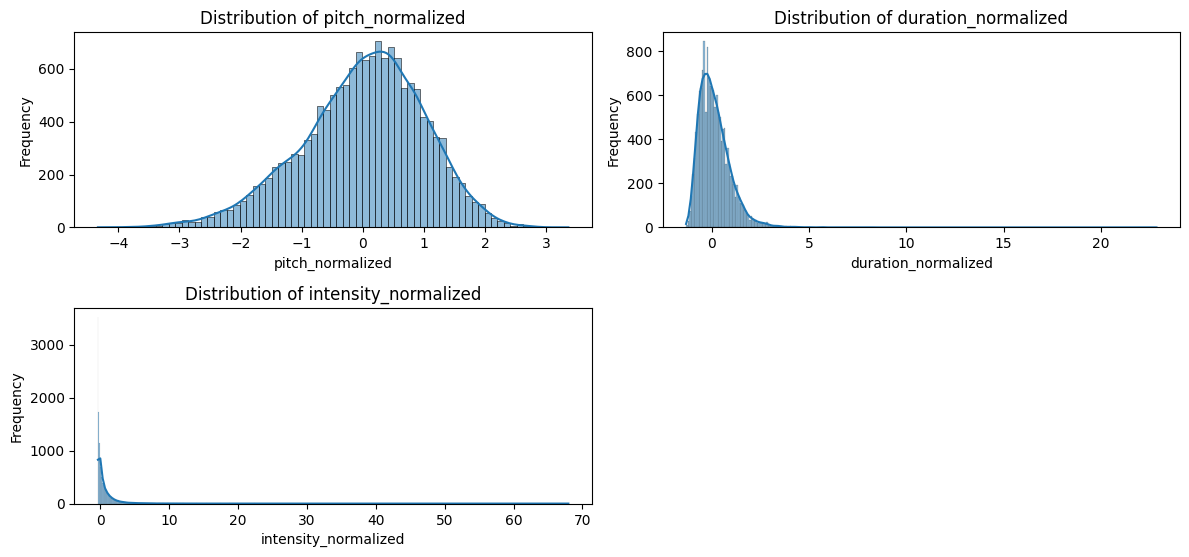

In [ ]:
# Plotting histograms to visualize distribution of numerical features
plt.figure(figsize=(12, 8))

for i, feature in enumerate(normalized_numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(audio_data_df_normalized[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

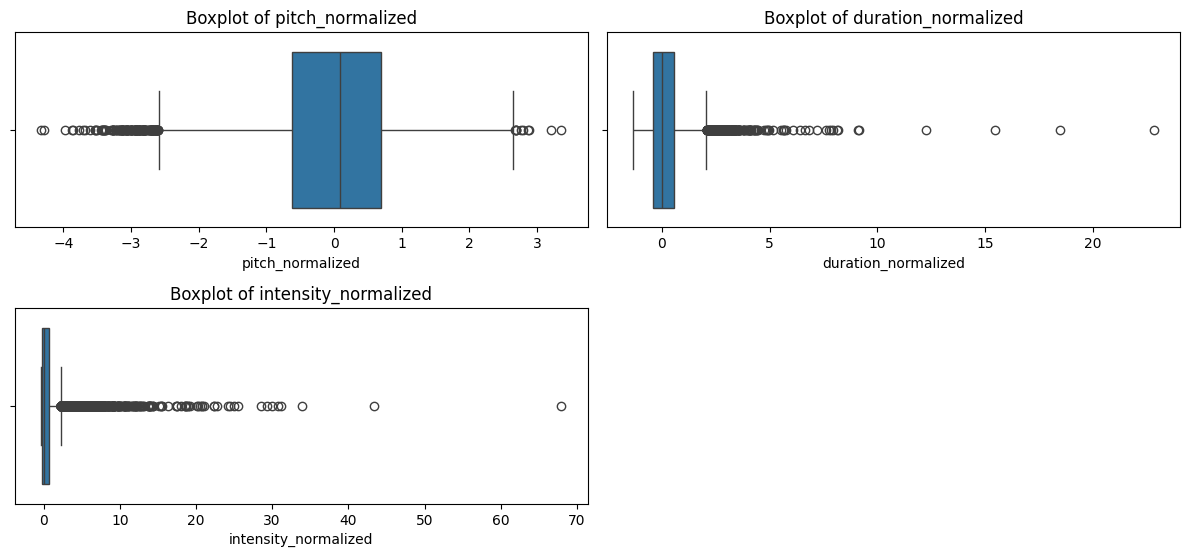

In [ ]:
# Detecting outliers using boxplots
plt.figure(figsize=(12, 8))

for i, feature in enumerate(normalized_numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=audio_data_df_normalized[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

##### _**EDA**: For the processed data_

In [63]:
audio_data_df.head()

filename  \
0  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
1  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
2  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
3  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   
4  C:\\Users\\user\\Desktop\\22I-0485_BS-AI-B_AI-...   

                                       transcription  up_votes  down_votes  \
0  learn to recognize omens and follow them the o...         1           0   
1         everything in the universe evolved he said         1           0   
2  you came so that you could learn about your dr...         1           0   
3  so now i fear nothing because it was those ome...         1           0   
4  if you start your emails with greetings let me...         3           2   

   age gender accent                                         audio_data  \
0   37   male     us  [-5.9227658e-11  1.6258904e-11  3.5964388e-11 ...   
1   37   male     us  [ 1.5570863e-12  1.9885526e-12  5.0891769e-12 ...   
2   37   male     us  [-1.5786802e-11 -4.9093251e-12 -7.5024278e-11 ...   
3   37   male     us  [-1.5923391e-11  2.6508585e-11 -9.1306103e-12 ...   
4   37   male     us  [1.0412913e-08 9.2886254e-12 2.6633327e-09 ......   

   sample_rate  duration  ...  transformed_duration_normalized  \
0        22050  4.104036  ...                         0.010487   
1        22050  7.560000  ...                         0.926762   
2        22050  5.064036  ...                         0.358789   
3        22050  6.648027  ...                         0.754396   
4        22050  4.896009  ...                         0.305938   

  transformed_intensity_normalized  transformed_number_of_words  \
0                         0.422303                     3.295837   
1                        -0.430247                     2.890372   
2                         0.135437                     3.044522   
3                        -0.390689                     3.258097   
4                         3.468882                     3.091042   

  transformed_tempo  transformed_f0_mean  transformed_f0_median  \
0          4.919975             0.588058               0.596394   
1          4.919975             0.588058               0.596394   
2          4.820660             0.588058               0.596394   
3          4.609003             0.588058               0.596394   
4          4.609003             0.588058               0.596394   

   transformed_f0_std  transformed_f0_5perc  transformed_f0_95perc  \
0            0.161236              0.397847               0.724492   
1            0.161236              0.397847               0.724492   
2            0.161236              0.397847               0.724492   
3            0.161236              0.397847               0.724492   
4            0.161236              0.397847               0.724492   

   transformed_gender_mapped  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  

[5 rows x 54 columns]

In [64]:
audio_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15001 entries, 0 to 15000
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   filename                          15001 non-null  object 
 1   transcription                     15001 non-null  object 
 2   up_votes                          15001 non-null  int64  
 3   down_votes                        15001 non-null  int64  
 4   age                               15001 non-null  int64  
 5   gender                            15001 non-null  object 
 6   accent                            15001 non-null  object 
 7   audio_data                        15001 non-null  object 
 8   sample_rate                       15001 non-null  int64  
 9   duration                          15001 non-null  float64
 10  pitch_f0                          15001 non-null  float64
 11  formants                          15001 non-null  object 
 12  inte

In [65]:
audio_data_df.describe()

up_votes    down_votes           age  sample_rate      duration  \
count  15001.000000  15001.000000  15001.000000      15001.0  15001.000000   
mean       2.545964      0.179788     37.231318      22050.0      4.421937   
std        7.579492      4.377489      9.151529          0.0      1.985715   
min        1.000000      0.000000     15.000000      22050.0      1.056009   
25%        1.000000      0.000000     37.000000      22050.0      3.096009   
50%        2.000000      0.000000     37.000000      22050.0      4.080000   
75%        3.000000      0.000000     37.000000      22050.0      5.376009   
max      745.000000    528.000000     85.000000      22050.0     56.184036   

           pitch_f0  intensity_rms  pitch_scaled  duration_scaled  \
count  15001.000000   1.500100e+04  1.500100e+04     15001.000000   
mean       0.800489   9.974380e+05 -3.514584e-16         0.149972   
std        0.174962   2.011128e+06  1.000033e+00         0.870928   
min        0.042256   6.190663e-01 -4.333857e+00        -1.326312   
25%        0.692745   9.543173e+04 -6.158385e-01        -0.431575   
50%        0.815561   3.745406e+05  8.614469e-02         0.000000   
75%        0.922846   1.162244e+06  6.993598e-01         0.568425   
max        1.388861   7.288005e+07  3.362973e+00        22.852647   

       intensity_scaled  ...  transformed_duration_normalized  \
count      15001.000000  ...                     1.474400e+04   
mean           0.583887  ...                             -inf   
std            1.885175  ...                              NaN   
min           -0.351083  ...                             -inf   
25%           -0.261629  ...                    -5.284982e-01   
50%            0.000000  ...                     1.048705e-02   
75%            0.738371  ...                     4.567584e-01   
max           67.964650  ...                     3.171895e+00   

       transformed_intensity_normalized  transformed_number_of_words  \
count                      15001.000000                 15001.000000   
mean                           0.199586                     2.849863   
std                            0.622792                     0.425048   
min                           -0.432451                     0.693147   
25%                           -0.303309                     2.564949   
50%                            0.000000                     2.890372   
75%                            0.552949                     3.178054   
max                            4.233594                     4.595120   

       transformed_tempo  transformed_f0_mean  transformed_f0_median  \
count       15001.000000         1.500100e+04           15001.000000   
mean            4.831655         5.880584e-01               0.596394   
std             0.177082         2.220520e-16               0.000000   
min             3.888786         5.880584e-01               0.596394   
25%             4.730455         5.880584e-01               0.596394   
50%             4.820660         5.880584e-01               0.596394   
75%             4.973658         5.880584e-01               0.596394   
max             5.558365         5.880584e-01               0.596394   

       transformed_f0_std  transformed_f0_5perc  transformed_f0_95perc  \
count        1.500100e+04          1.500100e+04           15001.000000   
mean         1.612355e-01          3.978468e-01               0.724492   
std          2.775650e-17          5.551300e-17               0.000000   
min          1.612355e-01          3.978468e-01               0.724492   
25%          1.612355e-01          3.978468e-01               0.724492   
50%          1.612355e-01          3.978468e-01               0.724492   
75%          1.612355e-01          3.978468e-01               0.724492   
max          1.612355e-01          3.978468e-01               0.724492   

       transformed_gender_mapped  
count               14944.000000  
mean                    0.064240  
std                     0.2010

In [66]:
audio_data_df.isnull().sum()

filename                               0
transcription                          0
up_votes                               0
down_votes                             0
age                                    0
gender                                 0
accent                                 0
audio_data                             0
sample_rate                            0
duration                               0
pitch_f0                               0
formants                               0
intensity_rms                          0
mfccs                                  0
pitch_scaled                           0
duration_scaled                        0
intensity_scaled                       0
pitch_normalized                       0
duration_normalized                    0
intensity_normalized                   0
noise_reduced                          0
trimmed_audio                          0
onsets                                 0
number_of_words                        0
tempo           

##### _Data Visualization of the audio features; specified for training_

In [9]:
numerical_columns_df = audio_data_df.select_dtypes(include=[np.number])

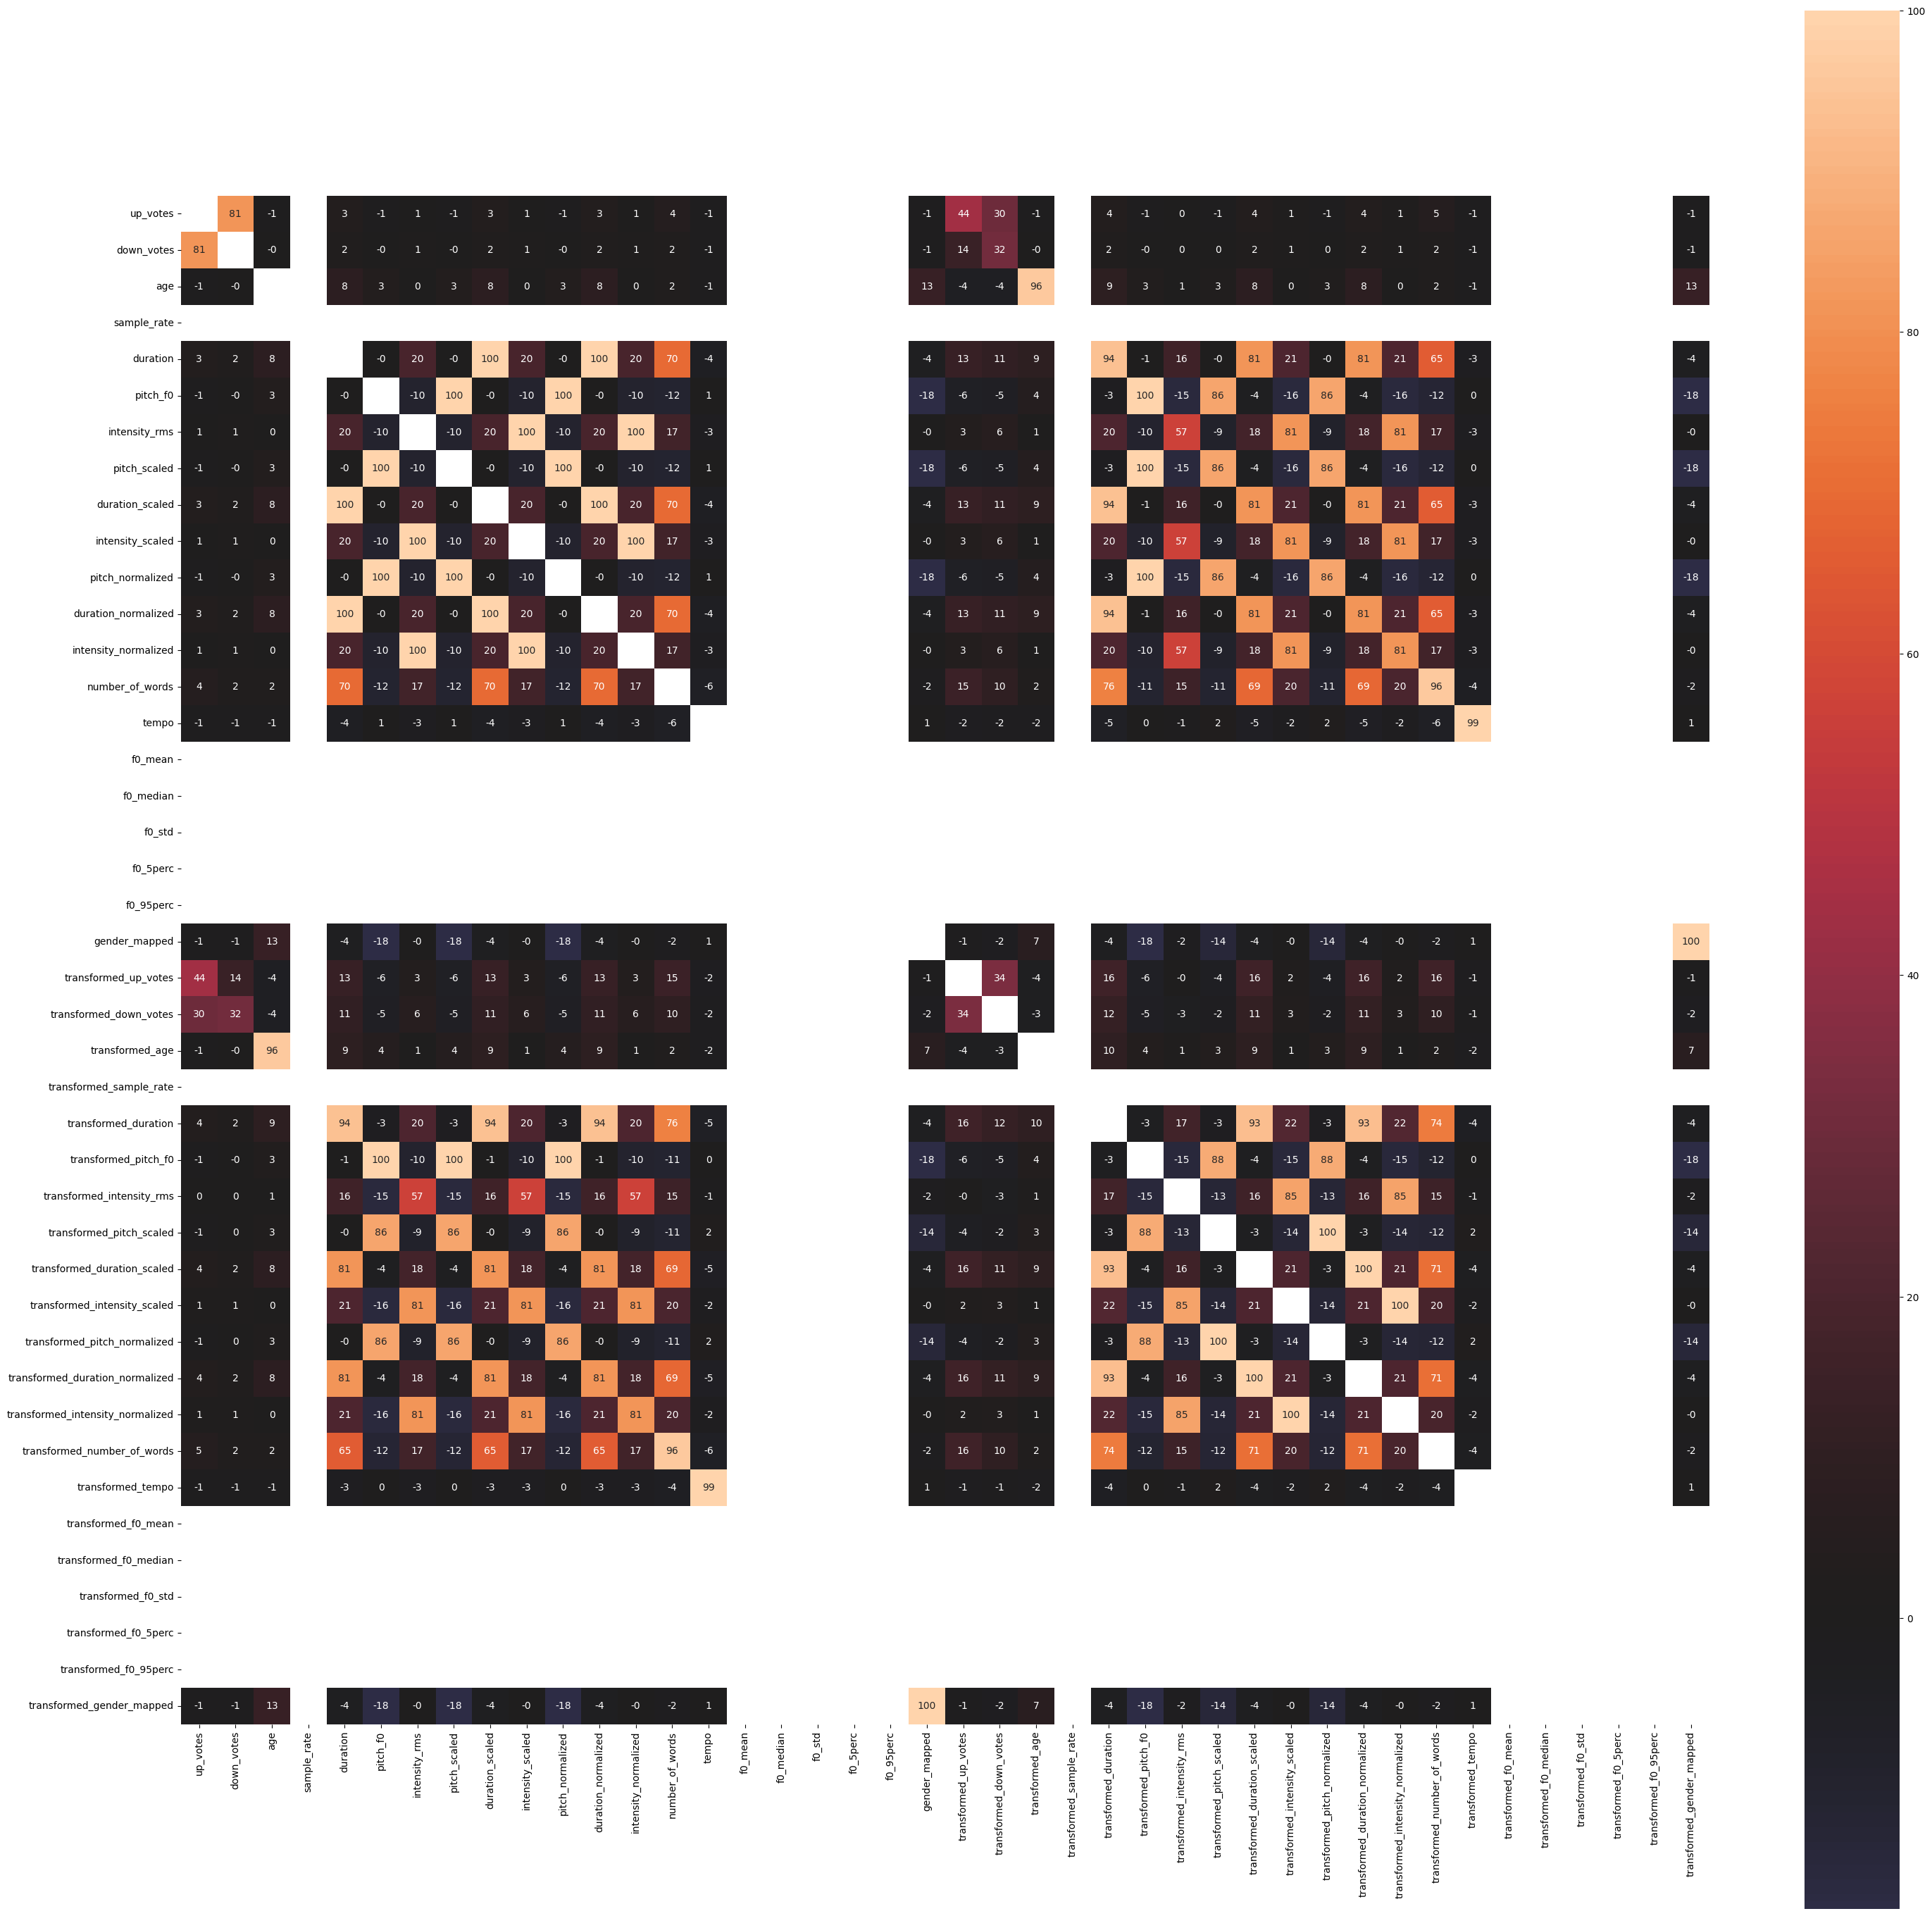

In [22]:
# Finding feature correlations; to determine the best features to utilize for training the dataset
plt.figure(figsize=(35, 35))

df_corr = numerical_columns_df.corr() * 100

sns.heatmap(df_corr, square=True, annot=True, fmt=".0f",
            mask=np.eye(len(df_corr)), center=0)
plt.show()

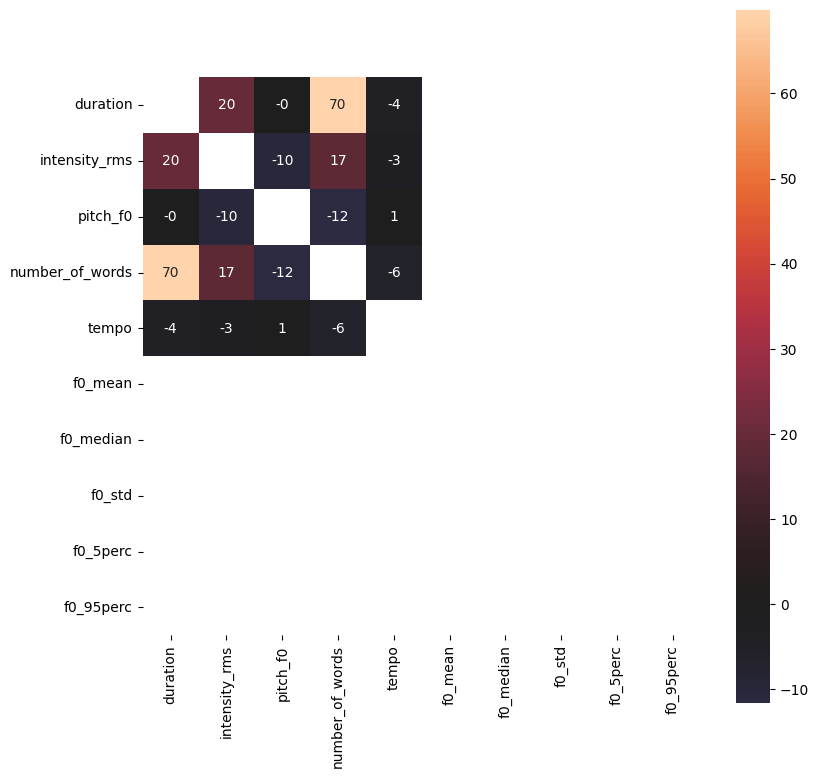

In [21]:
plt.figure(figsize=(9, 9))

df_corr = audio_data_df[training_features].corr() * 100

sns.heatmap(df_corr, square=True, annot=True, fmt=".0f",
            mask=np.eye(len(df_corr)), center=0)
plt.show()

In [ ]:
# audio_data_df.to_csv("audio_features_processed.csv", index=False) 

In [72]:
# audio_data_df.to_csv("audio_features_processed_updated.csv", index=False) 
# audio_data_df.to_csv("audio_features_processed_updated1.csv", index=False) 

In [83]:
audio_data_df1=pd.read_csv("audio_features_processed.csv")

### Model Training

##### Utility function for brute specific modelling

In [73]:
def y_pred(X_test, weights, bias):
    # Adding bias term to the feature matrix
    X_test_with_bias = np.c_[X_test, np.ones(X_test.shape[0])]

    # Performing prediction using the manually computed weights and bias
    y_pred = np.dot(X_test_with_bias, np.concatenate([weights, [bias]]))

    return y_pred

##### Implementation based function for brute specific modelling

In [74]:
def manual_linear_regression(x, y):
    # Adding a column of ones for bias
    x_with_bias = np.c_[x, np.ones(x.shape[0])]

    # Calculating X transpose
    x_transpose = x_with_bias.T

    # Calculating X transpose multiplied by X
    x_transpose_x = np.dot(x_transpose, x_with_bias)

    # Calculating the inverse of X_transpose_X
    x_transpose_x_inv = np.linalg.inv(x_transpose_x)

    # Calculating (X_transpose_X)^-1 multiplied by X transpose
    a = np.dot(x_transpose_x_inv, x_transpose)

    # Calculating the final parameters
    final = np.dot(a, y.reshape(-1, 1))

    # Extracting weights and bias
    weights = final[:-1]
    bias = final[-1]

    return final, weights, bias

##### Sample training features (Utilized for determining the best features that aid in acheiving better results)

In [113]:
training_features = ['duration', 'intensity_rms', 'pitch_f0', 'number_of_words', 'tempo', 'f0_mean', 'f0_median', 'f0_std', 'f0_5perc', 'f0_95perc']

training_features1 = ['duration', 'intensity_rms', 'pitch_f0', 'number_of_words', 'tempo', 'f0_mean', 'f0_median', 'f0_std', 'f0_5perc', 'f0_95perc', 'centroid_mean', 'bandwidth_mean',
       'contrast_mean']

training_features2 = ['duration', 'intensity_rms', 'pitch_f0', 'number_of_words', 'tempo', 'centroid_mean', 'bandwidth_mean',
       'contrast_mean']

training_features3 = ['duration_scaled', 'intensity_scaled', 'pitch_scaled', 'number_of_words', 'tempo', 'centroid_mean', 'bandwidth_mean',
       'contrast_mean']

training_features4 = ['sample_rate', 'duration', 'pitch_f0', 'intensity_rms', 'pitch_scaled', 'duration_scaled', 'intensity_scaled', 'tempo','centroid_mean', 'bandwidth_mean',
       'contrast_mean'] 

##### Splitting the datasets into training and testing halfs

In [114]:
X = audio_data_df1[training_features3].to_numpy()
y = audio_data_df1[['age']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

##### Training based upon brute specific approach

In [115]:
final_params, weights, bias =manual_linear_regression(X_train, y_train)

In [116]:
predicted_y = np.dot(np.c_[X_test, np.ones(X_test.shape[0])], final_params)

rounded_y = predicted_y.astype(int)

##### Training based upon "sklearn" specific approach

In [125]:
model = LinearRegression()

model.fit(X_train, y_train)

train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
test_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

### Model Evaluation

##### Evaluation based upon brute specific approach

In [117]:
mse = ((rounded_y - y_test.flatten()) ** 2).mean()

print("Model Evaluation for the Brute Specific Model: ", mse)

Model Evaluation for the Brute Specific Model:  83.02548068110045


##### Evaluation based upon "sklearn" specific approach

In [127]:
print("Model Evaluation for the 'sklearn' Specific Model")
print(f"> Train RMSE; {train_rmse}")
print(f"> Test RMSE; {test_rmse}")

predictions = model.predict(X_test)

Model Evaluation for the 'sklearn' Specific Model
> Train RMSE; 9.071277890299804
> Test RMSE; 9.249996820141492


##### _**EDA**: For, training data results_

In [128]:
predictions_test = model.predict(X_test)

test_data_with_predictions = X_test.copy()

test_data_with_predictions=pd.DataFrame(test_data_with_predictions)

test_data_with_predictions['age_encoded'] = y_test
test_data_with_predictions['predicted_age_encoded'] = predictions_test

In [129]:
test_data_with_predictions

0           1         2     3           4         5         6  \
0     8.184036  7828778.00  0.785615  40.0  117.453835  0.800489  0.815561   
1     3.504036   964706.50  0.625301  18.0  107.666016  0.800489  0.815561   
2     7.128027  3465218.50  0.610360  34.0  107.666016  0.800489  0.815561   
3     5.136009  2837835.50  0.724157  21.0  117.453835  0.800489  0.815561   
4     2.376009    97366.63  0.968954   9.0  123.046875  0.800489  0.815561   
...        ...         ...       ...   ...         ...       ...       ...   
2996  3.864036   389046.38  0.940648  19.0  117.453835  0.800489  0.815561   
2997  3.480000  2006832.90  0.868226  15.0   89.102909  0.800489  0.815561   
2998  4.704036  1650616.00  0.771804  25.0  103.359375  0.800489  0.815561   
2999  3.120000   167409.77  0.635617   9.0  129.199219  0.800489  0.815561   
3000  6.264036  1534510.90  0.795444  14.0  135.999178  0.800489  0.815561   

             7         8         9  age_encoded  predicted_age_encoded  
0     0.174962  0.488616  1.063683           37              37.440406  
1     0.174962  0.488616  1.063683           25              36.631603  
2     0.174962  0.488616  1.063683           37              37.338094  
3     0.174962  0.488616  1.063683           25              37.287636  
4     0.174962  0.488616  1.063683           35              36.996435  
...        ...       ...       ...          ...                    ...  
2996  0.174962  0.488616  1.063683           37              37.073632  
2997  0.174962  0.488616  1.063683           37              37.144359  
2998  0.174962  0.488616  1.063683           55              36.933655  
2999  0.174962  0.488616  1.063683           37              37.009807  
3000  0.174962  0.488616  1.063683           37              38.450393  

[3001 rows x 12 columns]

In [119]:
# Making predictions using the linear regression model
y_pred = np.dot(X_test, weights) + bias


# Rounding the predictions to the nearest integer as age is typically an integer value
y_pred_rounded = np.round(y_pred)


# Converting the predicted and actual values to integers for comparison
y_pred_rounded = y_pred_rounded.astype(int)
y_test = y_test.astype(int)


# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rounded)

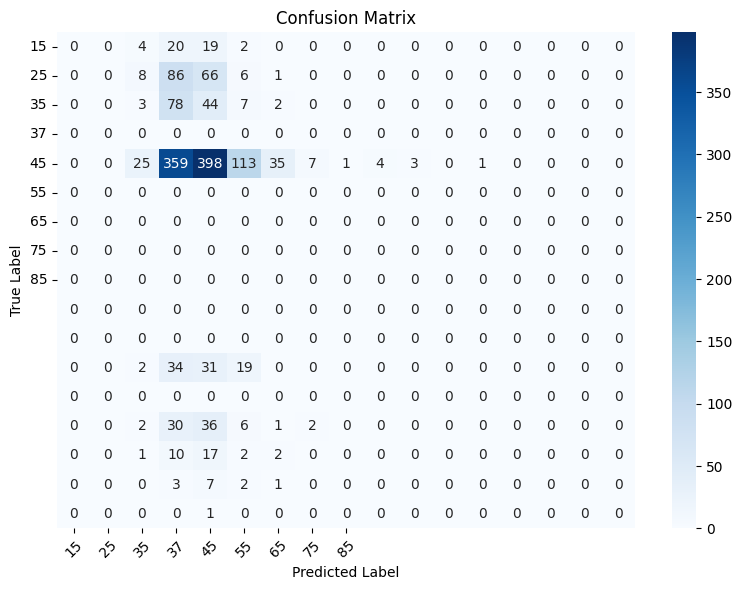

In [120]:
# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test, rounded_y)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Defining the gradient descent function
def gradient_descent(m, b, data, lr):
    N = float(len(data))
    
    m_gradient = 0
    b_gradient = 0
    
    for i in range(len(data)):
        x = data[i, 0]
        y = data[i, 1]
        m_gradient += -(2/N) * x * (y - (m*x + b))
        b_gradient += -(2/N) * (y - (m*x + b))
    
    new_m = m - (lr * m_gradient)
    new_b = b - (lr * b_gradient)
    
    return new_m, new_b

# Defining the loss function (mean squared error)
def loss_function(m, b, data):
    total_error = 0
    
    for i in range(len(data)):
        x = data[i, 0]
        y = data[i, 1]
        total_error += (y - (m*x + b))**2
    
    return total_error / float(len(data))

# Defining the plot_data function to visualize the data and the fitted line
def plot_data(m, b, data):
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points')
    plt.plot(data[:, 0], m*data[:, 0] + b, color='red', label='Fitted Line')
    plt.title('Linear Regression with Gradient Descent')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

data=X

# Initializing the values of m and b to 0
m = 0
b = 0

# Setting the learning rate and number of epochs for gradient descent
lr = 0.0001
epochs = 500

Epoch 0 - Error: 3.8943687518358296


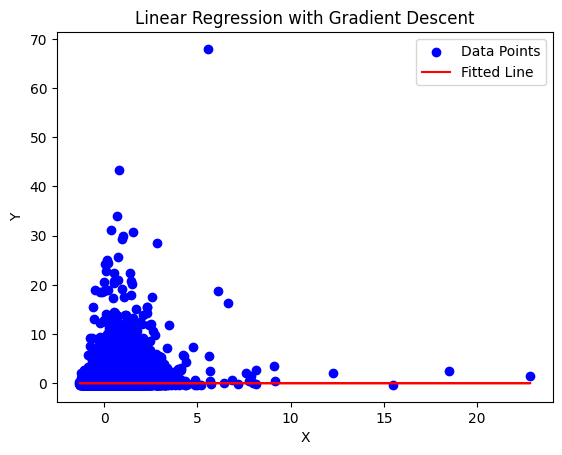

Epoch 50 - Error: 3.884283871722956


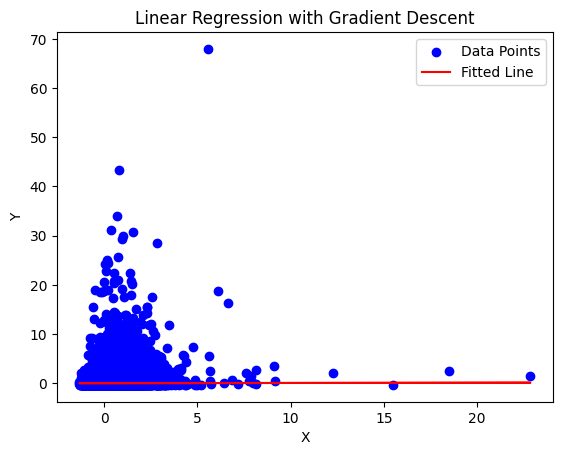

Epoch 100 - Error: 3.874412252487768


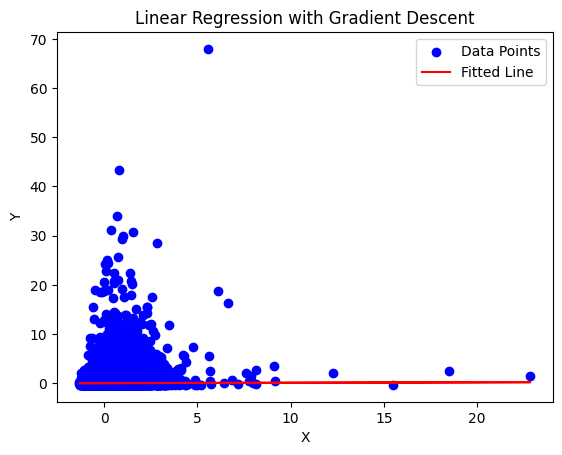

Epoch 150 - Error: 3.864749373619575


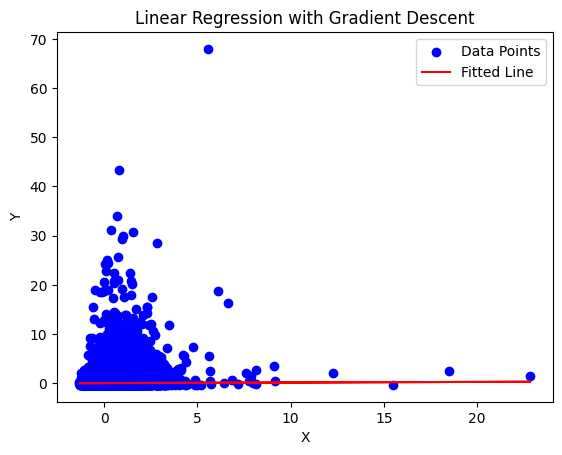

Epoch 200 - Error: 3.8552908105811388


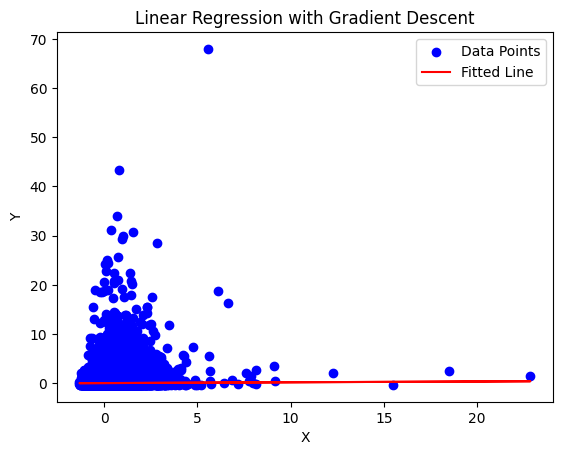

Epoch 250 - Error: 3.8460322327690086


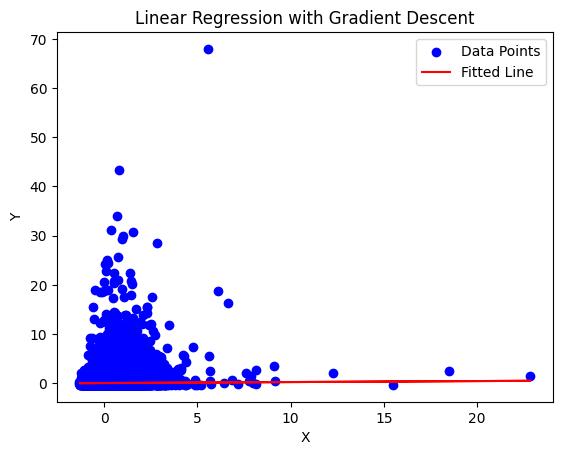

Epoch 300 - Error: 3.8369694015171785


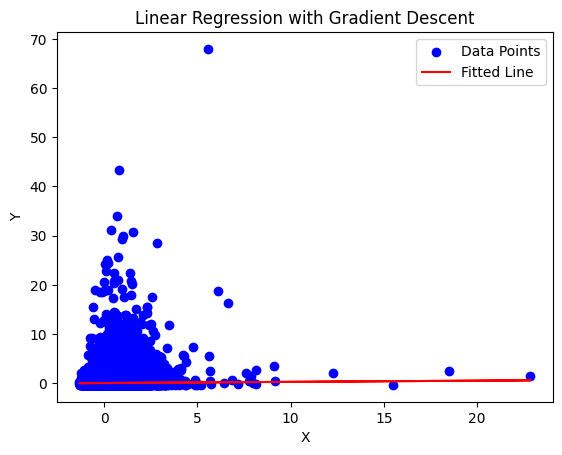

Epoch 350 - Error: 3.828098168143256


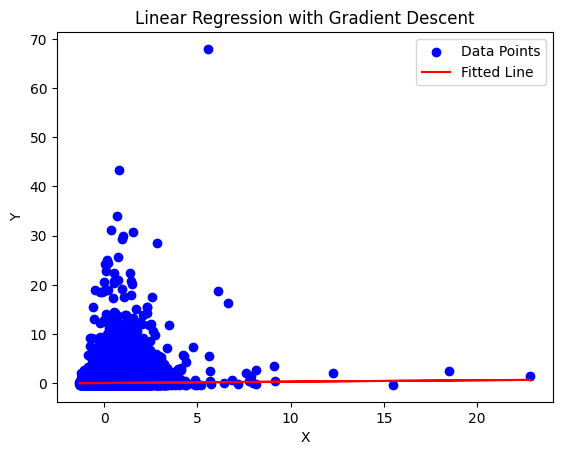

Epoch 400 - Error: 3.819414472035945


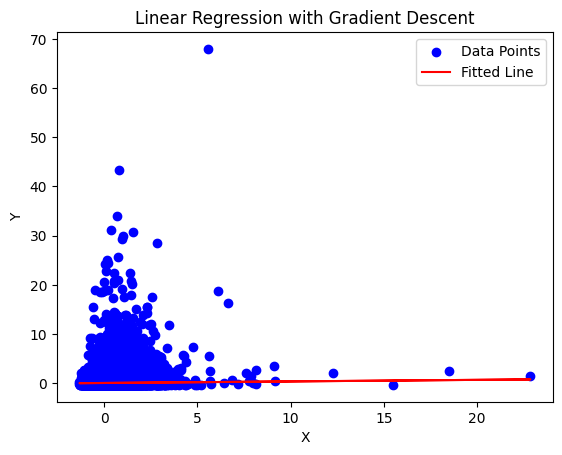

Epoch 450 - Error: 3.8109143387836943


In [122]:
# Performing gradient descent for the specified number of epochs
for i in range(epochs):
    # Updating m and b using gradient descent
    m, b = gradient_descent(m, b, data, lr)

    # With every 50 epochs, plot the data and the current line being fit to the data
    if i % 50 == 0:
        print("Epoch {0} - Error: {1}".format(i, loss_function(m, b, data)))
        plot_data(m, b, data)
        plt.show()
        input('Press enter to continue...')

print("m = {0}, b = {1}".format(m, b))